In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [63]:
import numpy as np

import torch
import random
import math
import json

from tqdm import tqdm_notebook
from boltons.iterutils import pairwise
from scipy.stats import kendalltau
from itertools import permutations

from sent_order.models.kt_regression import SentenceEncoder, Regressor, Corpus
from sent_order.perms import sample_uniform_perms

In [4]:
sent_encoder = torch.load(
    '../../data/models/new/kt-reg/sent_encoder.366.bin',
    map_location={'cuda:0': 'cpu'},
)

In [5]:
regressor = torch.load(
    '../../data/models/new/kt-reg/regressor.366.bin',
    map_location={'cuda:0': 'cpu'},
)

/Users/dclure/Projects/plot-ordering/env/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'sent_order.models.kt_regression.Regressor' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
train = Corpus('../../data/dev.json/', 10000)

100%|██████████| 10000/10000 [00:01<00:00, 6913.28it/s]


In [352]:
grafs = [g for g in train.grafs if len(g.sentences) == 5]

In [353]:
len(grafs)

1647

In [381]:
graf = random.choice(grafs)

In [382]:
[' '.join(s.tokens) for s in graf.sentences]

['The structures of the recently reported ordered perovskites SrLa(FeTi)O6 and BaLa(FeTi)O6 have been revisited using Rietveld analysis of the powder x - ray diffraction data .',
 'Our studies clearly show that earlier authors have incorrectly reported the tetragonal structure in the I4/m space group for SrLa(FeTi)O6 and the cubic structure in the Fm3 m space group for BaLa(FeTi)O6 .',
 'The correct structure is found to be orthorhombic in the Pnma space group for SrLa(FeTi)O6 while cubic in the Pm3 m space group for BaLa(FeTi)O6 .',
 'Thus the BaLa(FeTi)O6 is not an ordered double perovskite as the occupancies of Ba / La ions at A - site and Fe / Ti ions at B - site are disordered resulting in the primitive cubic unit cell in the Pm3 m space group .',
 'Similarly , the occupancies of Sr / La ions at A - site and Fe / Ti ions at B - site are disordered in SrLa(FeTi)O6 also , ruling out the ordered perovskite structure .']

In [383]:
sents = sent_encoder(graf.sentence_variables())

In [384]:
sents

Variable containing:
 7.9208e-04 -2.6485e-06 -6.3739e-04  ...  -2.0126e-05  5.4750e-05 -3.0014e-05
-5.9216e-02  7.0801e-05 -1.5260e-03  ...  -1.6134e-04  9.0240e-04 -2.4356e-04
-7.8055e-03 -1.0790e-03  3.3321e-03  ...   1.4946e-03 -9.2047e-07  7.1921e-04
 1.0416e-04  2.1130e-04  8.9083e-05  ...  -1.0920e-02  1.2185e-04  4.9256e-03
 5.8460e-04 -6.3224e-07  4.1061e-03  ...  -9.7704e-03 -4.9293e-05 -1.6599e-03
[torch.FloatTensor of size 5x1000]

In [385]:
perms = list(permutations(range(5)))

In [386]:
x = []
kts = []
for perm in tqdm_notebook(perms):
    
    sort = torch.LongTensor(perm)
    x.append(sents[sort])
    
    kt = kendalltau(perm, range(5)).correlation
    kts.append(kt)

HBox(children=(IntProgress(value=0, max=120), HTML(value='')))

In [387]:
x = torch.stack(x)
y = regressor(x)

In [388]:
y = (1-y)*2-1

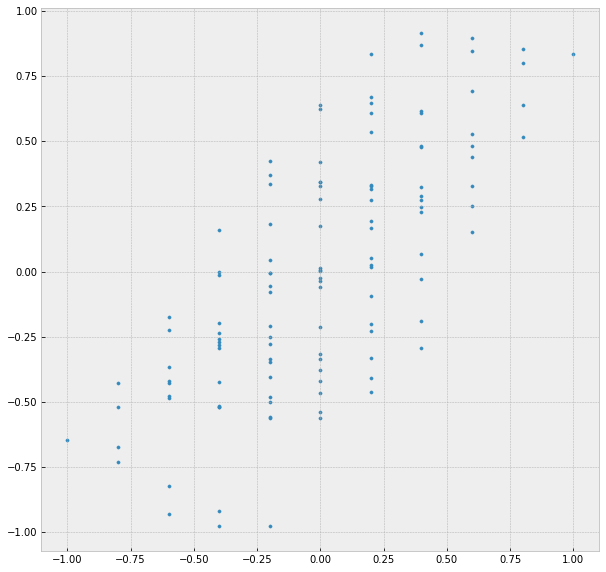

In [396]:
plt.figure(figsize=(10,10))
plt.scatter(kts, y.data.tolist(), s=10)

In [399]:
zeros = []
for perm, kt_true, kt_pred in zip(perms, kts, y.data.tolist()):
    if kt_true == 0:
        zeros.append((perm, kt_true, kt_pred))

In [400]:
sorted(zeros, key=lambda x: x[2])

[((1, 3, 2, 4, 0), 0.0, -0.5626935958862305),
 ((1, 3, 4, 0, 2), 0.0, -0.5371706485748291),
 ((1, 2, 4, 3, 0), 0.0, -0.46625804901123047),
 ((1, 4, 0, 3, 2), 0.0, -0.42013704776763916),
 ((3, 1, 2, 0, 4), 0.0, -0.3759772777557373),
 ((1, 4, 2, 0, 3), 0.0, -0.33577096462249756),
 ((3, 1, 0, 4, 2), 0.0, -0.3166158199310303),
 ((2, 1, 3, 4, 0), 0.0, -0.21117734909057617),
 ((3, 0, 4, 1, 2), 0.0, -0.05836749076843262),
 ((4, 0, 1, 3, 2), 0.0, -0.034522294998168945),
 ((2, 3, 1, 0, 4), 0.0, -0.02481842041015625),
 ((3, 2, 0, 1, 4), 0.0, 0.0017380714416503906),
 ((2, 1, 4, 0, 3), 0.0, 0.005830287933349609),
 ((4, 1, 0, 2, 3), 0.0, 0.014684200286865234),
 ((0, 4, 3, 1, 2), 0.0, 0.1733860969543457),
 ((2, 3, 0, 4, 1), 0.0, 0.2798879146575928),
 ((4, 0, 2, 1, 3), 0.0, 0.3296201229095459),
 ((2, 4, 0, 1, 3), 0.0, 0.34245193004608154),
 ((3, 0, 2, 4, 1), 0.0, 0.34531474113464355),
 ((0, 3, 4, 2, 1), 0.0, 0.42119085788726807),
 ((2, 0, 4, 3, 1), 0.0, 0.6239376068115234),
 ((0, 4, 2, 3, 1), 0.0, 0.